<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#OLS" data-toc-modified-id="OLS-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>OLS</a></span><ul class="toc-item"><li><span><a href="#Unpooled" data-toc-modified-id="Unpooled-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Unpooled</a></span><ul class="toc-item"><li><span><a href="#All-logs" data-toc-modified-id="All-logs-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>All logs</a></span></li><li><span><a href="#Logs-or-squares" data-toc-modified-id="Logs-or-squares-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Logs or squares</a></span></li></ul></li><li><span><a href="#Pooled" data-toc-modified-id="Pooled-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Pooled</a></span></li></ul></li><li><span><a href="#Linear-model-with-elastic-net-regularization" data-toc-modified-id="Linear-model-with-elastic-net-regularization-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Linear model with elastic net regularization</a></span><ul class="toc-item"><li><span><a href="#Unpooled" data-toc-modified-id="Unpooled-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Unpooled</a></span></li><li><span><a href="#Pooled" data-toc-modified-id="Pooled-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Pooled</a></span></li></ul></li><li><span><a href="#Save-performance" data-toc-modified-id="Save-performance-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Save performance</a></span></li></ul></div>

In [2]:
# Importing libraries
import pdb 
import glob
import copy
import math
# import pickle
import csv

import numpy as np
import pandas as pd
import scipy as sp

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
 
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, \
    StratifiedShuffleSplit, cross_val_score, KFold
#     GridSearchCV, RandomizedSearchCV

# from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, \
    ElasticNet
#     LogisticRegressionCV, SGDClassifier
# from sklearn.svm import SVC, LinearSVC
# from sklearn.ensemble import RandomForestClassifier, \
#     ExtraTreesClassifier

from sklearn.externals import joblib
from sklearn.utils import resample
# from sklearn.utils.fixes import signature

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval, pyll
# import xgboost as xgb
# from xgboost.sklearn import XGBRegressor

# Set up pandas table display
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Set plotting options
sns.set() # Use seaborn defaults for plotting
%matplotlib inline 

# # Load line profiler
# %load_ext line_profiler

# Adjust number of CPU cores to use
N_JOBS=3

In the previous notebook, we trained a gradient boosting model, in order to have the flexibility to model non-linear relationships and interactions between the predictors. Gradient boosting, and in particular the version I used, XGBoost, is known to deliver some of the most accurate predictions.  In fact, on anything short of huge data sets with at least millions of observations, where deep learning is likely to perform best, it is probably the most accurate individual model. 

However, in practice linear regression is often the method of choice, because of its simplicity as well as its better interpretability. Thus, let’s see for comparison what accuracy we achieve using OLS. After that, I will add regularization to these models to avoid overfitting the model to the particular data we have at hand.  This will show that, if we want to include many parameters in the model (e.g., to take into account the effect of variables like the different metropolitan areas), regularization is important in order to get good performance on new data.
By the same token, this also shows that we need to rethink how we evaluate the performance of a model: If we want to use the explained variance, it is not enough to simply use the adjusted R_2, since this adjustment is not done in any principled way.  Rather, we need to withhold data when training the model, and then evaluate the performance of the model (e.g., by calculating the R_2) on these withheld data.

Let's load the data from the previous note book and perform the specific preprocessing steps necessary for linear models.

In [ ]:
data_train = joblib.load('../data/data_train_lin')
data_test = joblib.load('../data/data_test_lin')

Since we will encode year using one-hot encoding (i.e., using dummy variables), we need to deal with the fact that the test set has years not found in the training set. The best solution seems to be to set the new years to the last year for which we have data.  Our training set goes to mid-2016, gives and a test set goes from mid-2016 to 2017.Therefore, we simply said all years in the test set to 2016, which should give us the best possible results.

In [133]:
# Set year for test set to the most recent year
data_test.year = 2016

## OLS 

### Unpooled
#### All logs 

First, we will perform one-hot encoding for categorical variables. By contrast to the previous notebook, we will also treat the ordinal variable, hotel category, as categorical. This is necessary because linear models would otherwise wrongly treat the variable as measured on an interval-scale, which is unlikely to be appropriate (this would assume that the difference between each succeeding pair of categories is identical in size).

For the models without regularization, we need to drop the first category of each categorical variable in order to avoid collinearity. This is not so easy to achieve with the python data science stack, because we normally would not want to estimate a model without regularization. Pandas.get_dummies() does offer this possibility, but it then does not give us the option to transform the training data using the same encoding. Thus, the best option is to use scikit-learn's one-hot encoder on each categorical column individually. I will store these in a list, and then drop the first column before concatenating these new data frames. 

In [206]:
# Categorical variables
cats = ['msa', 'tract', 'location', 'category',
        'saleaffiliation', 'operation', 'year', 'quarter']
# Instantiate one-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore',
                    sparse=False)
# Create lists to store encodings for each variable
X_train_cats = []
X_test_cats = []
feature_names_cats = []
# Iterate through categorical variables
for cat in cats:
    # Encode variable i for TEST data
    ohe_train_i = ohe.fit_transform(
                data_train.loc[:, [cat]])
    # Encode variable i for TRAIN data
    ohe_test_i = ohe.transform(
                data_test.loc[:, [cat]])
    
    # Discard first column and save
    X_train_cats.append(ohe_train_i[:,1:])
    X_test_cats.append(ohe_test_i[:,1:])
    
    # Save feature names (w/o first column)
    feature_names_cats.extend(
        ohe.get_feature_names()[1:])

In [207]:
# List of variables to exclude from X
v2exclude= list(
    data_train.columns[
        data_train.columns.str.contains(r'_[23]')]) # Polynomials
v2exclude.extend(
    ['landsf', 'age', 'largestmeetingspace', 'sizesf', # Levels
     'rooms','floors'])
v2exclude.extend(
    ['saleprice', 'log_saleprice', 'id', 'new'])
# Print to make sure no variables are accidentally excluded
print('Variables excluded: ', v2exclude)

Variables excluded:  ['year_2', 'year_3', 'age_2', 'age_3', 'floors_2', 'landsf', 'age', 'largestmeetingspace', 'sizesf', 'rooms', 'floors', 'saleprice', 'log_saleprice', 'id', 'new']


In [208]:
# Non-categorical columns for X
X_train_rest= data_train.drop(cats + v2exclude,
                               axis=1)
X_test_rest= data_test.drop(cats + v2exclude,
                             axis=1)
# Merge categorical and non-categorical variables
X_train= np.concatenate([X_train_rest] + X_train_cats, 
                         axis=1)
X_test= np.concatenate([X_test_rest] + X_test_cats, 
                         axis=1)

# Get feature names
feature_names= list(X_train_rest.columns) \
    + feature_names_cats
# Create target variables
y_train = data_train.loc[:, 'log_saleprice']
y_test = data_test.loc[:, 'log_saleprice']

Let's go ahead and train the model.  Even though I removed the first category of each categorical variable for which I used one-hot-encoding, I also had to remove the intercept in order to get a reasonable prediction on the test set. (With the intercept, I got a negative R^2.)  Even though statisticians have developed tools to dig deeper into collinearity to find out which variables are causing the problem, I don't waste any time on this. As explained above, there is no reason to estimate a model without regularization anyway, except for demonstration purposes.

In [209]:
from sklearn.linear_model import LinearRegression
lr= LinearRegression(fit_intercept=False)
lr.fit(X_train, y_train)
# Get sorted coefficients with feature names
coef= pd.Series(
    lr.coef_,
    index=feature_names) \
    .sort_values(ascending=False)

In [210]:
# Print results for non-categorical variables
pd.DataFrame(coef 
    .loc[~ coef.index.str.startswith('x')]) \
    .sort_index() \
    .style.format('{:.5F}')

,0
allsuites,-0.01566
boutique,-0.03987
casino,0.74781
cbd,0.72929
conference,0.22607
convention,0.32923
golf,0.10225
indoorcorridors,0.01384
log1_age,-0.11058
log1_landsf,0.00363


In [211]:
# R_2 on TRAINING set
y_lr= lr.predict(X_train)
r2_lr_train = r2_score(y_train, y_lr)
r2_lr_train

0.8567275967358019

In [212]:
# R_2 on TEST set
y_lr= lr.predict(X_test)
r2_lr= r2_score(y_test, y_lr)
r2_lr

0.5850465400933892

Let's wait with interpreting these results until the next notebook, where we can compare the results from all models.  Thus, we will store these results for later. 

In [213]:
r2_up = [r2_lr_train, r2_lr]
r2_up

[0.8567275967358019, 0.5850465400933892]

#### Logs or squares
Now let's estimate the same type of model but with different predictors: Instead of using all logs for numeric variables, I will follow Das et al (2017) and instead use a square term for age and floors, as well as a the levels (rather than log) for the amount of land included.

In [218]:
v2include = \
        ['allsuites', 'boutique', 'casino', 'cbd', 
         'conference', 'convention', 'golf', 'indoorcorridors',
         'multiproperty', 'portfolio', 'restaurant', 
         'ski', 'spa', 'landsf', 'age', 'age_2',
         'log1_largestmeetingspace', 'log_sizesf', 'log_rooms', 
         'floors', 'floors_2', 'selfrun']

In [219]:
# Non-categorical columns for X
X_train_rest= data_train.loc[:, v2include]
X_test_rest= data_test.loc[:, v2include]

# Merge categorical and non-categorical variables
X_train= np.concatenate([X_train_rest] + X_train_cats, 
                         axis=1)
X_test= np.concatenate([X_test_rest] + X_test_cats, 
                         axis=1)

# Get feature names
feature_names= list(X_train_rest.columns) \
    + feature_names_cats
# Create target variables
y_train = data_train.loc[:, 'log_saleprice']
y_test = data_test.loc[:, 'log_saleprice']

In [220]:
from sklearn.linear_model import LinearRegression
lr= LinearRegression(fit_intercept=False)
lr.fit(X_train, y_train)
# Get sorted coefficients with feature names
coef= pd.Series(
    lr.coef_,
    index=feature_names) \
    .sort_values(ascending=False)

In [221]:
# Print results for non-categorical variables
pd.DataFrame(coef 
    .loc[~ coef.index.str.startswith('x')]) \
    .sort_index() \
    .style.format('{:.5F}')

,0
age,-0.00737
age_2,0.00004
allsuites,-0.01015
boutique,-0.04466
casino,0.73540
cbd,0.69365
conference,0.22503
convention,0.31264
floors,0.02832
floors_2,-0.00051


In [222]:
# R_2 on TRAINING set
y_lr= lr.predict(X_train)
r2_lr_train = r2_score(y_train, y_lr)
r2_lr_train

0.8565506116601053

In [223]:
# R_2 on TEST set
y_lr= lr.predict(X_test)
r2_lr= r2_score(y_test, y_lr)
r2_lr

0.5890885744341479

For comparison, let's print the results from the model using all logs.

In [224]:
# R_2 for model with all logs 
# (for training and test set, respectively)
r2_up

[0.8567275967358019, 0.5850465400933892]

We see that the two models performed very similarly, especially on the training set. On the test set, the model with polynomial terms performs slightly better than the model with all logs.  However, the difference is likely within the margin of error. (Indeed, when I tried a different specification that used a linear time trend, I got the reverse result.)  Thus, I will stick with the model with all logs for now, since this is more robust to outliers: As already mentioned, polynomials can give predictions that are far off for observations that have variables with extreme values, such as very old buildings.

### Pooled

The next step is to estimate the pooled model without regularization.  To do so, we first repeat the preprocessing steps but do not perform one-hot encoding for the three categorical variables that have a large number of categories.

In [225]:
# Categorical variables
cats = ['location', 'category', 'operation', 
        'year', 'quarter']
# Categorical variables to exclude
cats_out = ['msa', 'tract', 'saleaffiliation']
# Instantiate one-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore',
                    sparse=False)
# Create lists to store encodings for each variable
X_train_cats = []
X_test_cats = []
feature_names_cats = []
for cat in cats:
    # Encode variable i for TEST data
    ohe_train_i = ohe.fit_transform(
                data_train.loc[:, [cat]])
    # Encode variable i for TRAIN data
    ohe_test_i = ohe.transform(
                data_test.loc[:, [cat]])
    
    # Discard first column and save
    X_train_cats.append(ohe_train_i[:,1:])
    X_test_cats.append(ohe_test_i[:,1:])
    
    # Save feature names
    feature_names_cats.extend(
        ohe.get_feature_names()[1:])

In [226]:
# List of variables to exclude from X
v2exclude= list(
    data_train.columns[
        data_train.columns.str.contains(r'_[23]')]) # Polynomials
v2exclude.extend(
    ['landsf', 'age', 'largestmeetingspace', 'sizesf', # Levels
     'rooms','floors'])
v2exclude.extend(
    ['saleprice', 'log_saleprice', 'id', 'new'])
# Print to make sure no variables are accidentally excluded
print('Variables excluded: ', v2exclude)

Variables excluded:  ['year_2', 'year_3', 'age_2', 'age_3', 'floors_2', 'landsf', 'age', 'largestmeetingspace', 'sizesf', 'rooms', 'floors', 'saleprice', 'log_saleprice', 'id', 'new']


In [227]:
# Non-categorical columns for X
X_train_rest= data_train.drop(cats + cats_out + v2exclude,
                               axis=1)
X_test_rest= data_test.drop(cats + cats_out + v2exclude,
                             axis=1)
# Merge categorical and non-categorical variables
X_train= np.concatenate([X_train_rest] + X_train_cats, 
                         axis=1)
X_test= np.concatenate([X_test_rest] + X_test_cats, 
                         axis=1)

# Get feature names
feature_names= list(X_train_rest.columns) \
    + feature_names_cats
# Create target variables
y_train = data_train.loc[:, 'log_saleprice']
y_test = data_test.loc[:, 'log_saleprice']

Now we are ready again to estimate the model.

In [228]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
# Get sorted coefficients with feature names
coef= pd.Series(
    lr.coef_,
    index=feature_names) \
    .sort_values(ascending=False)
coef

x0_Luxury Class             1.666332
x0_Upper Upscale Class      1.184319
x0_Upscale Class            0.898120
casino                      0.696283
x0_Upper Midscale Class     0.554321
log_rooms                   0.467119
x0_Urban                    0.315730
log_floors                  0.290715
convention                  0.281182
spa                         0.270852
portfolio                   0.254066
x0_Midscale Class           0.235429
conference                  0.230456
x0_Resort                   0.224743
golf                        0.135052
boutique                    0.130072
log_sizesf                  0.081230
restaurant                  0.042378
x0_4                        0.036075
allsuites                   0.028218
multiproperty               0.026801
x0_3                        0.018496
log1_largestmeetingspace   -0.013087
indoorcorridors            -0.020416
x0_2                       -0.025224
log1_landsf                -0.028681
cbd                        -0.040998
x

Let's print the explained variance for training and test set.

In [229]:
# R_2 on TRAINING set
y_lr= lr.predict(X_train)
r2_lr_train = r2_score(y_train, y_lr)
r2_lr_train

0.722600681359757

In [230]:
# R_2 on TEST set
y_lr= lr.predict(X_test)
r2_lr= r2_score(y_test, y_lr)
r2_lr

0.7810508365295534

In [231]:
# Save performance
r2_p = [r2_lr_train, r2_lr]
r2_p

[0.722600681359757, 0.7810508365295534]

Surprisingly, the model does a little better on the test set. On average, we would expect it to do worse. However, there is variance to our estimated performance on training and test set.  In our case, this variance is increased by the fact that we don't have a huge sample size (the test set contains about 1300 observations), and that we are using a single validation set rather than cross-validation in order to take into account the time-series nature of the data. Even more importantly, the training and test set do not come from the same distribution, because we split the data based on time.  It seems that the newer data were easier to predict, maybe because we have more data for the intercept of year.

## Linear model with elastic net regularization
### Unpooled

Let's perform the preprocessing steps again.  By contrast to the models without regularization, we do not get rid of the first category for each categorical variables.  The reason this is not necessary is that regularization is an alternative way to avoid collinearity.

In [232]:
# Categorical variables
cats = ['msa', 'tract', 'location', 'category',
        'saleaffiliation', 'operation', 'year',
        'quarter']
# Perform one-hot encoding
ohe = OneHotEncoder(handle_unknown='ignore',
                    sparse=False)
X_train_cats = ohe.fit_transform(
    data_train.loc[:, cats])        
X_test_cats = ohe.transform(
    data_test.loc[:, cats])

In [233]:
# List of variables to exclude from X
v2exclude= list(
    data_train.columns[
    data_train.columns.str.contains(r'_[23]')]) # Polynomials
v2exclude.extend(
    ['landsf', 'age', 'largestmeetingspace', 'sizesf', # Levels
     'rooms','floors'])
v2exclude.extend(
    ['saleprice', 'log_saleprice', 'id', 'new'])
# Print to make sure no variables are accidentally excluded
print('Variables excluded: ', v2exclude)

Variables excluded:  ['year_2', 'year_3', 'age_2', 'age_3', 'floors_2', 'landsf', 'age', 'largestmeetingspace', 'sizesf', 'rooms', 'floors', 'saleprice', 'log_saleprice', 'id', 'new']


In [234]:
# Non-categorical columns for X
X_train_rest= data_train.drop(cats + v2exclude,
                               axis=1)
X_test_rest= data_test.drop(cats + v2exclude,
                             axis=1)
# Merge categorical and non-categorical variables
X_train_up = np.concatenate([X_train_rest, X_train_cats], 
                         axis=1)
X_test_up = np.concatenate([X_test_rest, X_test_cats], 
                         axis=1)
# X_train_up = X_train_up.drop(
#     v2exclude, axis=1)
# X_test_up = X_test_up.drop(
#     v2exclude, axis=1)

# Get feature names
feature_names= list(X_train_rest.columns) \
    + list(ohe.get_feature_names())

# Create target variables
y_train = data_train.loc[:, 'log_saleprice']
y_test = data_test.loc[:, 'log_saleprice']

We can no go ahead and train the model.  Like for gradient boosting, will use Hyperopt to perform Bayesian hyperparameters optimization.  It probably does not lead to any big increase in performance or decrease in computational cost compared to a brute-force search, because computational costs for a linear model are relatively low anyways for a data set of our size. But since it is not too much of a burden to adapt the  code from XGBoost, we might as well reuse it just in case.

In [235]:
# Function to carry out hyperparameter optimization
def find_best_hp(LEARNER, space, model_name, 
                 X_train, y_train, 
                 adjust_params=None,n_folds=5, n_jobs=-1, max_evals=20):
    """Find best hyperparameters for a given regressor and search space."""
    
    # Trials object to track progress (not currently used)
    trials = Trials()

    # CSV file to track progress
    progress_file_path = '../progress_' + model_name + '.csv'
    with open(progress_file_path, 'w') as file:
        writer = csv.writer(file)
        # Write header to the file
        writer.writerow(['loss', 'params'])

    # Objective function to minimize
    def objective(params, LEARNER=LEARNER, 
                  progress_file_path=progress_file_path,
                  n_folds=n_folds, n_jobs=n_jobs):
        """Objective function to minimize"""
        
        # Adjust parameters, if specified
        if adjust_params is not None:
            params = adjust_params(params)
    
        # Instantiate LEARNER
        learner = LEARNER(**params)
        
        ## Generate indices for cross-validation
        # If only one "fold" is desired, split into train and validation set
        if n_folds == 1: 
            cv = ShuffleSplit(n_splits=1, test_size=.2, 
                                        random_state=1)
        # Otherwise, generate indices for proper cross-validation split
        else:  
            cv = KFold(n_folds, random_state=1)

        # Compute average precision through CV / validation set
        score = cross_val_score(learner, X_train, y_train, cv=cv,
                                scoring='r2', n_jobs=n_jobs)
        # Compute loss as the negative mean of the average precision scores
        # (since hyperopt can only minimize a function)
        loss = -score.mean()
        
        # Save results to csv file
        with open(progress_file_path, 'a') as file:
            writer = csv.writer(file)
            writer.writerow([loss, params])
        
        # Return results
        return {'loss': loss, 'params': params, 'status': STATUS_OK}
    
    # Minimize objective
    best = fmin(objective, space, algo=tpe.suggest,
                max_evals=max_evals, trials=trials)

    # Get the values of the optimal parameters
    best_params = space_eval(space, best)
    # Adjust best parameters, if specified
    if adjust_params is not None:
        best_params = adjust_params(best_params)

    # Re-fit the model with the optimal hyperparamters
    learner = LEARNER(**best_params)
    learner.fit(X_train, y_train)
    
    # Save model to disk
    joblib.dump(learner, '../saved_models/' + model_name + '.joblib')
    
    # Print best parameters
    print(best_params)

In [236]:
MAX_EVALS = 50
N_FOLDS = 20

# Search space (also includes constant parameters)
space = {
    'max_iter': 1000,
    'tol':1E-3,
    'random_state': 1,
    'alpha': hp.lognormal('alpha', np.log(1E-4), 4),
    'l1_ratio': hp.uniform('l1_ratio', 0, 1)
}

# Find best hyperparameters (defined above)
find_best_hp(ElasticNet, space, model_name='el_up',
              X_train=X_train_up, y_train=y_train,
              max_evals=MAX_EVALS, n_jobs=3, n_folds=N_FOLDS)

{'alpha': 0.0002751641657386846, 'l1_ratio': 0.5503451245739095, 'max_iter': 1000, 'random_state': 1, 'tol': 0.001}


In [237]:
# Load saved model, if necessary
el_up = joblib.load('../saved_models/el_up.joblib')

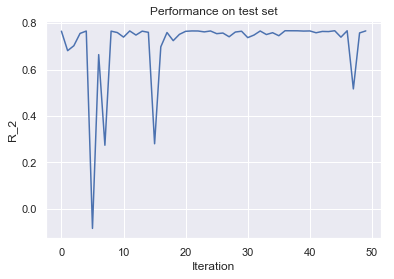

In [238]:
# Load full results from progress file
el_up_results = pd.read_csv('../progress_el_up.csv')

# Get validation score
# Extract AP for each iteration
r2_el_up = - el_up_results.loss

# Plot r2 per iteration
r2_el_up.plot()
plt.title('Performance on test set')
plt.ylabel('R_2')
plt.xlabel('Iteration');

This reveals that optimizing hyperparameters to regularize a linear model is relatively simple, so performance seems pretty stable without much improvement for further iterations.

In [239]:
# R_2 on TRAINING set
y_el_up = el_up.predict(X_train_up)
r2_el_up_train = r2_score(y_train, y_el_up)
r2_el_up_train

0.8455297953337058

In [240]:
# R_2 on TEST set
y_el_up = el_up.predict(X_test_up)
r2_el_up = r2_score(y_test, y_el_up)
r2_el_up

0.8475558636319633

In [241]:
# Save performance
r2_up_r = [r2_el_up_train, r2_el_up]
r2_up_r

[0.8455297953337058, 0.8475558636319633]

Examining the explained variance reveals that regularization gave us a boost in performance.  However, as mentioned above, we will save a comparison for a final notebook.

Let's print the coefficients, ignoring the intercepts for all categorical variables in order to limit the size of the table.

In [242]:
# Get sorted coefficients with feature names
coef= pd.Series(
    el_up.coef_,
    index=feature_names) \
    .sort_values(ascending=False)

# Print results for non-categorical variables
pd.DataFrame(coef 
    .loc[~ coef.index.str.startswith('x')]) \
    .sort_index() \
    .style.format('{:.5F}')

,0
allsuites,0.03674
boutique,0.03764
casino,0.65405
cbd,0.21244
conference,0.16512
convention,0.32810
golf,0.12423
indoorcorridors,0.01002
log1_age,-0.11188
log1_landsf,-0.00451


### Pooled
Finally, we will re-estimate the model for the pooled case. Again, we do not drop the first category when performing one-hot encoding, since regularization effectively deals with collinearity.

In [280]:
# Categorical variables to include
cats = ['location', 'category', 'operation', 
        'year', 'quarter']
# Categorical variables to exclude
cats_out = ['msa', 'tract', 'saleaffiliation']
# Perform one-hot encoding
ohe = OneHotEncoder(handle_unknown='ignore',
                    sparse=False)
X_train_cats = ohe.fit_transform(
    data_train.loc[:, cats])        
X_test_cats = ohe.transform(
    data_test.loc[:, cats])

In [281]:
# List of variables to exclude from X
v2exclude= list(
    data_train.columns[
    data_train.columns.str.contains(r'_[23]')]) # Polynomials
v2exclude.extend(
    ['landsf', 'age', 'largestmeetingspace', 'sizesf', # Levels
     'rooms','floors'])
v2exclude.extend(
    ['saleprice', 'log_saleprice', 'id', 'new'])
# Print to make sure no variables are accidentally excluded
print('Variables excluded: ', v2exclude)

Variables excluded:  ['year_2', 'year_3', 'age_2', 'age_3', 'floors_2', 'landsf', 'age', 'largestmeetingspace', 'sizesf', 'rooms', 'floors', 'saleprice', 'log_saleprice', 'id', 'new']


In [282]:
# Non-categorical columns for X
X_train_rest= data_train.drop(cats  + cats_out+ v2exclude,
                               axis=1)
X_test_rest= data_test.drop(cats + cats_out+ v2exclude,
                             axis=1)
# Merge categorical and non-categorical variables
X_train_p = np.concatenate([X_train_rest, X_train_cats], 
                         axis=1)
X_test_p = np.concatenate([X_test_rest, X_test_cats], 
                         axis=1)

In [283]:
# Get feature names
feature_names= list(X_train_rest.columns) \
    + list(ohe.get_feature_names())

# Create target variables
y_train = data_train.loc[:, 'log_saleprice']
y_test = data_test.loc[:, 'log_saleprice']

In [276]:
MAX_EVALS = 50
N_FOLDS = 20

# Search space (also includes constant parameters)
space = {
    'max_iter': 1000,
    'tol':1E-3,
    'random_state': 1,
    'alpha': hp.lognormal('alpha', np.log(1E-4), 4),
    'l1_ratio': hp.uniform('l1_ratio', 0, 1)
}

# Find best hyperparameters (defined above)
find_best_hp(ElasticNet, space, model_name='el_p',
              X_train=X_train_p, y_train=y_train,
              max_evals=MAX_EVALS, n_jobs=3, n_folds=N_FOLDS)

{'alpha': 3.7701515352783604e-05, 'l1_ratio': 0.9952987471092946, 'max_iter': 1000, 'random_state': 1, 'tol': 0.001}


In [300]:
# Load saved model, if necessary
el_p = joblib.load('../saved_models/el_p.joblib')

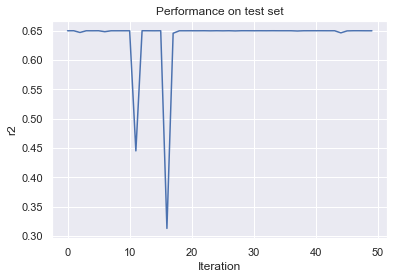

In [301]:
# Load full results from progress file
el_results = pd.read_csv('../progress_el_p.csv')

# Get validation score
# Extract AP for each iteration
r2_el_p = - el_results.loss

# Plot r2 per iteration
r2_el_p.plot()
plt.title('Performance on test set')
plt.ylabel('r2')
plt.xlabel('Iteration');

When examining how the performance change over the iterations of the hyperparameters optimization, we see that it stayed almost stable.  This is due to the fact that hyperparameters optimization for this case is easy (compared, e.g., what we saw for gradient boosting, where we optimized over a higher-dimensional space.)

In [302]:
# R_2 on TRAINING set
y_el_p = el_p.predict(X_train_p)
r2_el_p_train = r2_score(y_train, y_el_p)
r2_el_p_train

0.7225784583731365

In [305]:
# R_2 on TEST set
y_el_p = el_p.predict(X_test_p)
r2_el_p = r2_score(y_test, y_el_p)
r2_el_p

0.7809748676982142

In [306]:
# Save performance
r2_p_r = [r2_el_p_train, r2_el_p]
r2_p_r

[0.7225784583731365, 0.7809748676982142]

In [307]:
# Get sorted coefficients with feature names
coef= pd.Series(
    el_p.coef_,
    index=feature_names) \
    .sort_values(ascending=False)

# Print results for non-categorical variables
pd.DataFrame(coef 
    .loc[~ coef.index.str.startswith('x')]) \
    .sort_index() \
    .style.format('{:.5F}')

,0
allsuites,0.02801
boutique,0.12914
casino,0.68205
cbd,-0.04083
conference,0.22401
convention,0.28051
golf,0.13117
indoorcorridors,-0.01987
log1_age,-0.12246
log1_landsf,-0.02854


## Save performance
Finally, we concatenate the performance of all linear models into a data frame and save it to disk. We will load this in the final notebook, where we compare the performance of these models with each other and with the performance of gradient boosting.

In [309]:
# Combine all R_2 scores from OLS
r2_lin = pd.DataFrame([r2_up, r2_p, r2_up_r, r2_p_r],
             columns=['Train', 'Test'],
             index=['OLS, unpooled, no reg.',
                    'OLS, pooled, no reg.',
                    'linear regression, unpooled, elastic net reg.',
                    'linear regression, pooled, elastic net reg.']
)
joblib.dump(r2_lin, '../saved_models/r2_lin.joblib')

['../saved_models/r2_lin.joblib']

In [1]:
import os
os.system('jupyter nbconvert --to html 2_modeling_linear.ipynb')

0

In [2]:
os.getcwd()

'C:\\Users\\t\\Desktop\\projects\\hotels\\FINAL'